In [ ]:
!pip install pymaxflow
!git clone https://github.com/jiyuuchc/cellcutter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.4/798.4 kB 24.1 MB/s eta 0:00:00
Cloning into 'cellcutter'...
remote: Enumerating objects: 621, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 621 (delta 3), reused 0 (delta 0), pack-reused 615
Receiving objects: 100% (621/621), 60.60 MiB | 15.57 MiB/s, done.
Resolving deltas: 100% (387/387), done.
Updating files: 100% (45/45), done.


In [ ]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from glob import glob


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
Thu Apr 27 17:04:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |       

In [ ]:
import sys
sys.path.append('cellcutter')

import time
from os.path import join

import numpy as np
from numpy.random import default_rng
np.set_printoptions(precision=4)

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['image.cmap'] = 'gray'

import cellcutter
import cellcutter.utils

(-0.5, 199.5, 199.5, -0.5)

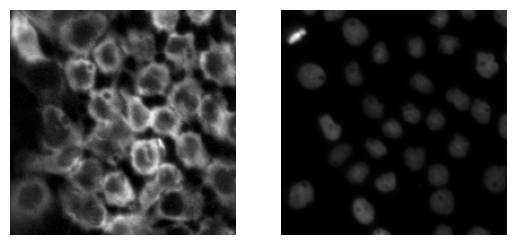

In [ ]:
# Load some image data

data = np.load('cellcutter/data/a1data.npz')
train_data = data['data']
input_img = train_data[...,0]
nucleus_img = train_data[..., 2]

# Check the images
fig, ax = plt.subplots(1,2)
ax[0].imshow(input_img[100:300,200:400])
ax[0].axis('off')
ax[1].imshow(nucleus_img[100:300,200:400])
ax[1].axis('off')

(-0.5, 199.5, 199.5, -0.5)

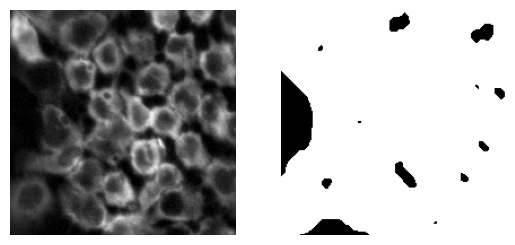

In [ ]:
## Defined the area of analysis
mask = cellcutter.utils.graph_cut(input_img, prior = 0.985, max_weight=10, sigma = 0.03)

#check results
fig, ax = plt.subplots(1,2)
ax[0].imshow(input_img[100:300,200:400])
ax[0].axis('off')
ax[1].imshow(mask[100:300,200:400])
ax[1].axis('off')

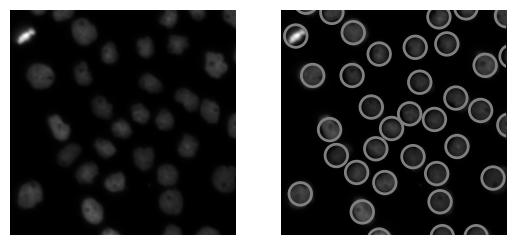

In [ ]:
## Get the marker locations

# Use a simple blob detection function
from cellcutter.markers import blob_detection
markers = blob_detection(nucleus_img, 10, 5, 0.1)

# check the result
xs, ys = markers.transpose()
label = np.zeros(shape = nucleus_img.shape, dtype=int)
label[(xs,ys)] = 1
fig, ax = plt.subplots(1,2)
ax[0].imshow(nucleus_img[100:300,200:400])
ax[0].axis('off')
ax[1].imshow(nucleus_img[100:300,200:400])
ax[1].axis('off')
for y,x in markers:
  y -= 100
  x -= 200
  c = plt.Circle((x, y), 10, color='gray', linewidth=2, fill=False)
  ax[1].add_patch(c)

In [ ]:
import sys
sys.path.append('cellcutter')

import time
from os.path import join

import numpy as np
from numpy.random import default_rng
np.set_printoptions(precision=4)

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['image.cmap'] = 'gray'

import cellcutter
import cellcutter.utils


# CNN segmentation with epochs of 10
dataset = cellcutter.Dataset(input_img, markers, mask_img = ~mask) # actually need the inverse of the mask

start = time.time()
model = cellcutter.UNet4(bn=True)
cellcutter.train_self_supervised(dataset, model, n_epochs = 10)

print('Elapsed time: %f'%(time.time() - start))

Epoch: 1 (32 steps) -- loss: 3321.442383
Epoch: 2 (64 steps) -- loss: 1705.519531
Epoch: 3 (96 steps) -- loss: 869.631104
Epoch: 4 (128 steps) -- loss: 338.290710
Epoch: 5 (160 steps) -- loss: 174.964706
Epoch: 6 (192 steps) -- loss: -50.202385
Epoch: 7 (224 steps) -- loss: -178.640915
Epoch: 8 (256 steps) -- loss: -302.720795
Epoch: 9 (288 steps) -- loss: -330.381744
Epoch: 10 (320 steps) -- loss: -408.950623
Elapsed time: 1384.240926


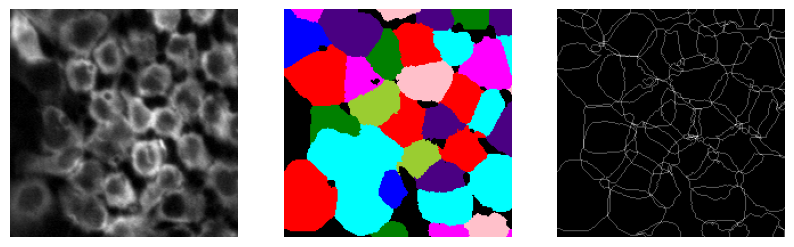

In [ ]:
# Check the segmentation results
from skimage.color import label2rgb

label = cellcutter.utils.draw_label(dataset, model, np.zeros_like(input_img, dtype=int))
rgb = label2rgb(label, bg_label = 0)
border = cellcutter.utils.draw_border(dataset, model, np.zeros_like(input_img, dtype=int))
fig, ax = plt.subplots(1,3,figsize = (10,7))
ax[0].imshow(input_img[100:300,200:400])
ax[0].axis('off')
ax[1].imshow(rgb[100:300,200:400])
ax[1].axis('off')
ax[2].imshow(border[100:300,200:400])
ax[2].axis('off')
plt.show()

In [ ]:
# CNN segmentation with epochs of 30
dataset = cellcutter.Dataset(input_img, markers, mask_img = ~mask) # actually need the inverse of the mask

start = time.time()
model = cellcutter.UNet4(bn=True)
cellcutter.train_self_supervised(dataset, model, n_epochs = 30)

print('Elapsed time: %f'%(time.time() - start))
# Check the segmentation results
from skimage.color import label2rgb

label = cellcutter.utils.draw_label(dataset, model, np.zeros_like(input_img, dtype=int))
rgb = label2rgb(label, bg_label = 0)
border = cellcutter.utils.draw_border(dataset, model, np.zeros_like(input_img, dtype=int))

Epoch: 1 (32 steps) -- loss: 2969.577881
Epoch: 2 (64 steps) -- loss: 1335.204834
Epoch: 3 (96 steps) -- loss: 701.384338
Epoch: 4 (128 steps) -- loss: 265.911163
Epoch: 5 (160 steps) -- loss: -65.688995
Epoch: 6 (192 steps) -- loss: -192.215912
Epoch: 7 (224 steps) -- loss: -274.959229
Epoch: 8 (256 steps) -- loss: -338.354065
Epoch: 9 (288 steps) -- loss: -481.735718
Epoch: 10 (320 steps) -- loss: -586.175598
Epoch: 11 (352 steps) -- loss: -617.293640
Epoch: 12 (384 steps) -- loss: -633.198059
Epoch: 13 (416 steps) -- loss: -688.981812
Epoch: 14 (448 steps) -- loss: -743.469238
Epoch: 15 (480 steps) -- loss: -739.479431
Epoch: 16 (512 steps) -- loss: -730.812317
Epoch: 17 (544 steps) -- loss: -782.627502
Epoch: 18 (576 steps) -- loss: -812.951294
Epoch: 19 (608 steps) -- loss: -809.204346
Epoch: 20 (640 steps) -- loss: -819.399109
Epoch: 21 (672 steps) -- loss: -836.438599
Epoch: 22 (704 steps) -- loss: -834.297241
Epoch: 23 (736 steps) -- loss: -836.007935
Epoch: 24 (768 steps) -- l

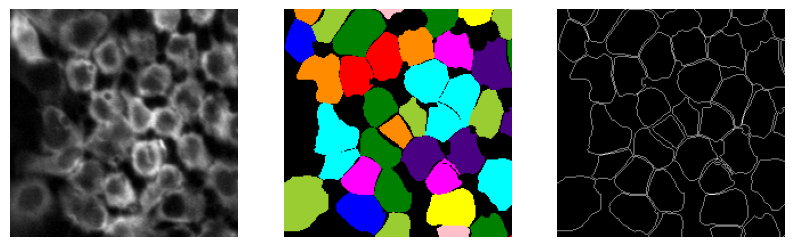

In [ ]:
fig, ax = plt.subplots(1,3,figsize = (10,7))
ax[0].imshow(input_img[100:300,200:400])
ax[0].axis('off')
ax[1].imshow(rgb[100:300,200:400])
ax[1].axis('off')
ax[2].imshow(border[100:300,200:400])
ax[2].axis('off')
plt.show()